<a href="https://colab.research.google.com/github/ReillyOareVT/HydroLearners_Proj/blob/main/mean_regression/Mean_Regression_Training_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mean Regression Model Training**
**Author:** Emma Reilly Oare
<br>**Date:** May 5, 2025
<br>**Purpose:** Training of mean regression model for EStreams dataset.

In [15]:
# Reinstall optuna each time (why? I don't know)
!pip install optuna

In [16]:
# Read in libs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import (
    RobustScaler,
    OneHotEncoder,
    PowerTransformer,
    QuantileTransformer
)
from sklearn.model_selection import (
    train_test_split,
    KFold,
    RepeatedKFold,
    cross_val_score
)
# from sklearn.metrics import (

# )
import xgboost as xgb
import optuna
from sklearn.pipeline import Pipeline
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import json


# Suppress warnings
warnings.filterwarnings("ignore")


In [17]:
# Only clone if the repo doesn't already exist
if not os.path.exists('/content/HydroLearners_Proj'):
    !git clone https://github.com/ReillyOareVT/HydroLearners_Proj

# Change directory
BASE_DIR = '/content/HydroLearners_Proj'
os.chdir(BASE_DIR)

# Confirm location
!pwd

/content/HydroLearners_Proj


## Step 1. Read in Data
The incoming dataset was selected using EDA and professional knowledge.

In [18]:
# Define path
reg_path = os.path.join(BASE_DIR, 'mean_regression', 'processed_data', 'mean_reg_model_ready_df.xlsx')

# Read in df
reg_df = pd.read_excel(reg_path).drop(columns = 'Unnamed: 0')

In [19]:
# Display df
reg_df

,Basin ID,Mean Daily Streamflow (log),Ratio of PET/Precipitation,Days/Year of Low Precipitation,Mean Terrain Slope (Degrees),Depth to Bedrock,Mean Aug NDVI,Mean Root Depth (cm),Mean Leaf-Area Index,% Unconsolidated Sediments,Mean % Soil Organic Material,Min Elevation (m),Days/Year with No Flow,Mean % Gravel in Soil,Fraction of Snow on Days <0 C,% Metamorphics,Mean NDVI,Stream Density (1000km/km2),Mean Soil Bulk Density (g/cm3),Lithological Dominant Class (Grouped)
0,AT000001,1.038155,0.395,198.993,24.122,1.124,0.645,81.571,0.092,22.064,1.218,420.622,0.000,9.062,0.326,23.464,0.329,0.151,1.303,Carbonate Sedimentary
1,AT000002,1.360464,0.390,204.041,26.095,0.565,0.696,58.600,0.089,0.000,1.820,674.209,0.000,8.140,0.332,88.549,0.342,0.151,1.502,Metamorphics
2,AT000003,-0.088830,0.411,202.001,25.735,0.593,0.655,51.660,0.087,0.070,1.714,583.510,0.000,10.294,0.337,84.653,0.313,0.141,1.425,Metamorphics
3,AT000004,1.625115,0.384,205.803,27.324,0.564,0.657,49.412,0.073,0.000,1.771,1022.324,0.000,13.044,0.361,59.940,0.276,0.095,1.409,Metamorphics
4,AT000005,1.199664,0.448,201.796,28.647,0.445,0.612,31.781,0.086,0.000,1.836,567.275,0.000,17.658,0.200,15.582,0.311,0.134,1.384,Carbonate Sedimentary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13418,UAGR0017,-1.897113,1.354,270.637,11.810,0.921,0.796,128.620,0.195,0.000,1.198,161.399,0.777,9.939,0.183,0.000,0.599,0.129,1.246,Siliciclastic Sedimentary
13419,UAGR0018,-0.744438,1.270,268.322,19.438,0.808,0.689,73.061,0.152,0.000,2.340,16.793,0.834,7.469,0.198,0.000,0.576,0.024,1.066,Carbonate Sedimentary
13420,UAGR0019,-1.164749,1.494,273.598,9.655,0.942,0.694,130.000,0.145,0.000,1.178,306.877,0.651,10.049,0.172,0.000,0.535,0.112,1.251,Carbonate Sedimentary
13421,UAGR0020,-2.590254,1.856,281.568,1.223,4.069,0.425,130.000,0.054,0.000,2.094,33.055,0.543,4.000,0.161,22.366,0.396,0.190,1.303,Acid Plutonic


## Step 2. Hyperparameter Optimization
We are using Optuna, a Bayesian optimization framework with Random Search integration. Features are transformed beforehand.

In [20]:
#  feature groups
quantile_features = [
    'Ratio of PET/Precipitation',
    'Days/Year of Low Precipitation',
    'Mean Terrain Slope (Degrees)',
    'Depth to Bedrock',
    'Mean Aug NDVI',
    'Mean Leaf-Area Index',
    'Mean % Soil Organic Material',
    'Min Elevation (m)',
    'Mean % Gravel in Soil',
    'Mean NDVI',
    'Mean Soil Bulk Density (g/cm3)',

]
sqrt_features = ['Fraction of Snow on Days <0 C']
cat_cols = ['Lithological Dominant Class (Grouped)']

pass_features = [
    'Mean Root Depth (cm)',
    '% Unconsolidated Sediments',
    'Days/Year with No Flow',
    '% Metamorphics',
    'Stream Density (1000km/km2)'
]

# Build preprocessor (no scaling needed for tree-based)
preprocessor = ColumnTransformer([
    ('quantile', QuantileTransformer(output_distribution='normal'), quantile_features),
    ('sqrt', FunctionTransformer(np.sqrt, validate=False), sqrt_features),
    ('pass', 'passthrough', pass_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='drop')

In [21]:
# Define X and y
X = reg_df[quantile_features + sqrt_features + pass_features + cat_cols]
y = reg_df['Mean Daily Streamflow (log)']

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [ ]:
# Define optuna objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'objective':        'reg:squarederror',
        'random_state':     42,
        'n_jobs':           -1,
    }

    # full pipeline
    model = Pipeline([
        ('preproc', preprocessor),
        ('xgb', xgb.XGBRegressor(**params))
    ])

    # 5-fold CV on training set
    scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    return -scores.mean()

# Run the study
xgb_study = optuna.create_study(direction='minimize', study_name = 'XGBoost Study')
xgb_study.optimize(objective, n_trials=50)

print("Best params:", xgb_study.best_params)

[I 2025-05-06 13:52:21,903] A new study created in memory with name: XGBoost Study
[I 2025-05-06 13:52:27,934] Trial 0 finished with value: 0.45491374242880633 and parameters: {'n_estimators': 158, 'max_depth': 3, 'learning_rate': 0.17656937659541827, 'subsample': 0.831914608904967, 'colsample_bytree': 0.952376306284472, 'reg_alpha': 5.923049552805745, 'reg_lambda': 1.1181683403912275e-08}. Best is trial 0 with value: 0.45491374242880633.
[I 2025-05-06 13:52:30,484] Trial 1 finished with value: 0.45206920967542175 and parameters: {'n_estimators': 434, 'max_depth': 3, 'learning_rate': 0.15634721570174845, 'subsample': 0.9355655757568483, 'colsample_bytree': 0.5257601548558233, 'reg_alpha': 0.1057604143121134, 'reg_lambda': 0.0023863157422693323}. Best is trial 1 with value: 0.45206920967542175.
[I 2025-05-06 13:53:03,234] Trial 2 finished with value: 0.435111358514888 and parameters: {'n_estimators': 767, 'max_depth': 7, 'learning_rate': 0.00857177147959753, 'subsample': 0.9470036352806

Best params: {'n_estimators': 709, 'max_depth': 8, 'learning_rate': 0.02018544626170335, 'subsample': 0.5417489744249561, 'colsample_bytree': 0.816449541662238, 'reg_alpha': 2.27012680471274, 'reg_lambda': 0.25344902173751155}


### Step 2a. Save Optimization Results

In [ ]:
# ----- Save results for later analysis -----

# Save study
study_path = os.path.join(BASE_DIR, 'xai', 'models_and_data', 'mean_reg', 'estreams_xgboost_model.pkl')
joblib.dump(xgb_study, study_path)

# Save train/test set
train_test_path = os.path.join(BASE_DIR, 'xai', 'models_and_data', 'mean_reg', 'xgb_train_test.pkl')
joblib.dump((X_train, X_test, y_train, y_test), train_test_path)

# Save only the best_params as JSON
params_path = os.path.join(BASE_DIR, 'xai', 'models_and_data', 'mean_reg', 'optuna_best_params.json')
with open(params_path, 'w') as f:
    json.dump(xgb_study.best_params, f, indent=4)

# Export every trial’s results
trials_df = xgb_study.trials_dataframe()
trials_path = os.path.join(BASE_DIR, 'xai', 'models_and_data', 'mean_reg', 'optuna_trial_results.csv')
trials_df.to_csv(trials_path, index=False)

### Step 2b. Optimization Results
Optuna allows us to visualize the optimization process. We'll include two plots below.

In [ ]:
# Identify best trials
best_trial = xgb_study.best_trial
best_params = best_trial.params  # Best hyperparameter combination
best_value = best_trial.value  # Best RMSE value
best_trial_number = best_trial.number

# Find position in the dataset
best_x = trial_numbers[trial_numbers == best_trial_number].values[0]
best_y = best_value

# Extract trial numbers and objective values
trials = xgb_study.trials_dataframe()
trials = trials[trials.state == "COMPLETE"]  # Only use completed trials
trial_numbers = trials.number
objective_values = trials.value

# Find best objective value over time
best_values = np.minimum.accumulate(objective_values)

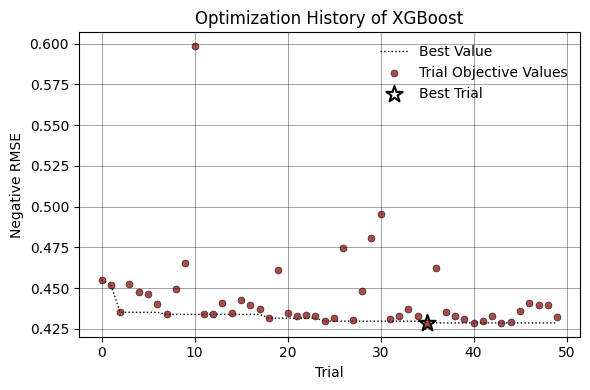

In [ ]:
# Create the figure
fig, ax = plt.subplots(figsize=(6, 4))

# Best value dotted line
ax.plot(trial_numbers, best_values, linestyle="dotted", color="black", linewidth=1, label="Best Value", zorder=2)

# Scatter plot for trials
sc = ax.scatter(
    trial_numbers, objective_values,
    color='maroon', edgecolors='black', facecolors='maroon', s=25,
    linewidths=0.5, alpha=0.7, label="Trial Objective Values",
    zorder=3
)
# Highlight the best trial
ax.scatter(best_x, best_y, color="white", edgecolors="black", s=150, marker="*", linewidths=1.5, label="Best Trial")

# Customizing aesthetics
ax.set_facecolor("white")
ax.grid(True, linestyle="-", linewidth=0.5, color="k", alpha=0.5, zorder=1)

# Labels and title
ax.set_xlabel("Trial")
ax.set_ylabel("Negative RMSE")
ax.set_title("Optimization History of XGBoost")

# Show legend
ax.legend(frameon=False, loc="best")
plt.tight_layout()

# Save fig
opt_hist_path = os.path.join(BASE_DIR, 'mean_regression', 'figures', 'optimization_history.png')
plt.savefig(opt_hist_path, dpi = 400)

# Display plot
plt.show()

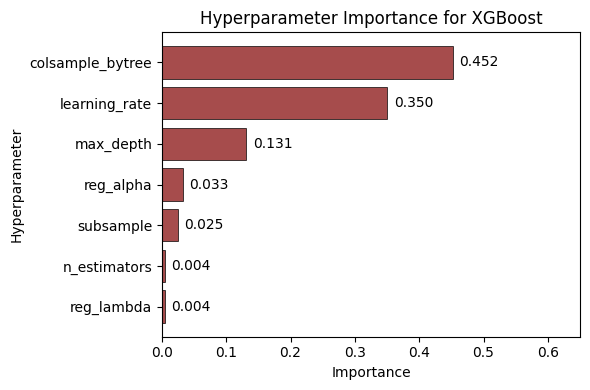

In [ ]:
# Get hyperparameter importance
importance = optuna.importance.get_param_importances(xgb_study)
params = list(importance.keys())
values = list(importance.values())

# Sort by importance (descending)
params, values = zip(*sorted(zip(params, values), key=lambda x: x[1], reverse=False))

# Create figure
fig, ax = plt.subplots(figsize=(6, 4))

# Horizontal bar plot
bars = ax.barh(params, values, color="maroon", edgecolor="black", linewidth=0.7, alpha=0.7)

# Customizing aesthetics
ax.set_facecolor("white")

# Labels and title
ax.set_xlim([0,0.65])
ax.set_xlabel("Importance")
ax.set_ylabel("Hyperparameter")
ax.set_title("Hyperparameter Importance for XGBoost")

# Show exact importance values on bars
for bar, value in zip(bars, values):
    ax.text(
        bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
        f"{value:.3f}", ha="left", va="center"
    )
plt.tight_layout()

# Save fig
opt_imp_path = os.path.join(BASE_DIR, 'mean_regression', 'figures', 'optimization_importance.png')
plt.savefig(opt_imp_path, dpi = 400)

# Show the plot
plt.show()

## Step 3. CV Evaluation
We will use 5-fold cross-validation (CV) to ensure there are no issues/discrepancies in the dataset (e.g., one test set is noisier than another).

In [22]:
# ------- Evaluation Function of CV -------

def kfold_model_metrics(model_name, model_builder, X, Y, cv=5, save_path=None):
    """
    Performs K-fold cross-validation and generates fully styled plots, including overall residuals.

    Parameters:
        model_name: Name of the model (used in plots and metric dataframe).
        model_builder: A function that returns a new, untrained model instance.
        X: Features.
        Y: Targets.
        cv: Number of folds.
        save_path: Directory to save figures.

    Returns:
        rmse_scores, mae_scores, r2_scores (list): Metrics for each fold.
    """

    rmse_scores = []
    mae_scores = []
    r2_scores = []

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    all_predictions = []
    all_true = []

    fig, axes = plt.subplots(cv, 2, figsize=(12, 5 * cv))

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index] if hasattr(X, "iloc") else X[train_index], X.iloc[test_index] if hasattr(X, "iloc") else X[test_index]
        Y_train, Y_test = Y.iloc[train_index] if hasattr(Y, "iloc") else Y[train_index], Y.iloc[test_index] if hasattr(Y, "iloc") else Y[test_index]

        # Create and train model
        model = model_builder()
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)

        predictions_np = np.array(predictions).flatten()
        Y_test_np = np.array(Y_test).flatten()

        all_predictions.extend(predictions_np)
        all_true.extend(Y_test_np)

        # Compute metrics
        rmse = np.sqrt(mean_squared_error(Y_test_np, predictions_np))
        mae = mean_absolute_error(Y_test_np, predictions_np)
        r2 = r2_score(Y_test_np, predictions_np)

        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)

        # Residuals plot
        residuals = Y_test_np - predictions_np
        axes[fold, 0].scatter(predictions_np, residuals, color='maroon', edgecolors='black', s=25, linewidths=0.5, alpha=0.5)
        axes[fold, 0].axhline(0, color='black', linestyle='dashed', linewidth=0.75)
        axes[fold, 0].set_title(f"Fold {fold+1} Residuals")
        axes[fold, 0].set_xlabel("Predicted Mean Streamflow (log mm/day)")
        axes[fold, 0].set_ylabel("Residuals (log mm/day)")

        # Predicted vs True plot
        axes[fold, 1].scatter(Y_test_np, predictions_np, color='maroon', edgecolors='black', s=25, linewidths=0.5, alpha=0.5)
        axes[fold, 1].plot([min(Y_test_np), max(Y_test_np)], [min(Y_test_np), max(Y_test_np)], color="black", linestyle="--", linewidth=0.75)
        axes[fold, 1].set_title(f"Fold {fold+1} Predicted vs. True")
        axes[fold, 1].set_xlabel("Observed Mean Streamflow (log mm/day)")
        axes[fold, 1].set_ylabel("Predicted Mean Streamflow (log mm/day)")


    plt.tight_layout()

    # Save figure if path is provided
    if save_path:
        residuals_path = os.path.join(save_path, f"{model_name}_cv_residuals.png")
        plt.savefig(residuals_path, dpi=300, bbox_inches='tight')

    plt.show()

    # Compute average metrics
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)

    print(f"The average {cv}-Fold Cross-Validation RMSE is {avg_rmse}")
    print(f"The average {cv}-Fold Cross-Validation MAE is {avg_mae}")
    print(f"The average {cv}-Fold Cross-Validation R-Squared is {avg_r2}")

    return rmse_scores, mae_scores, r2_scores

In [23]:
# Update best_params var
best_params = xgb_study.best_params.copy()
best_params.update({
    'objective':    'reg:squarederror',
    'random_state': 42,
    'n_jobs':       -1
})

# Define a builder for each CV fold
def build_xgb_pipeline():
    return Pipeline([
        ('preproc', preprocessor),
        ('xgb',     xgb.XGBRegressor(**best_params))
    ])

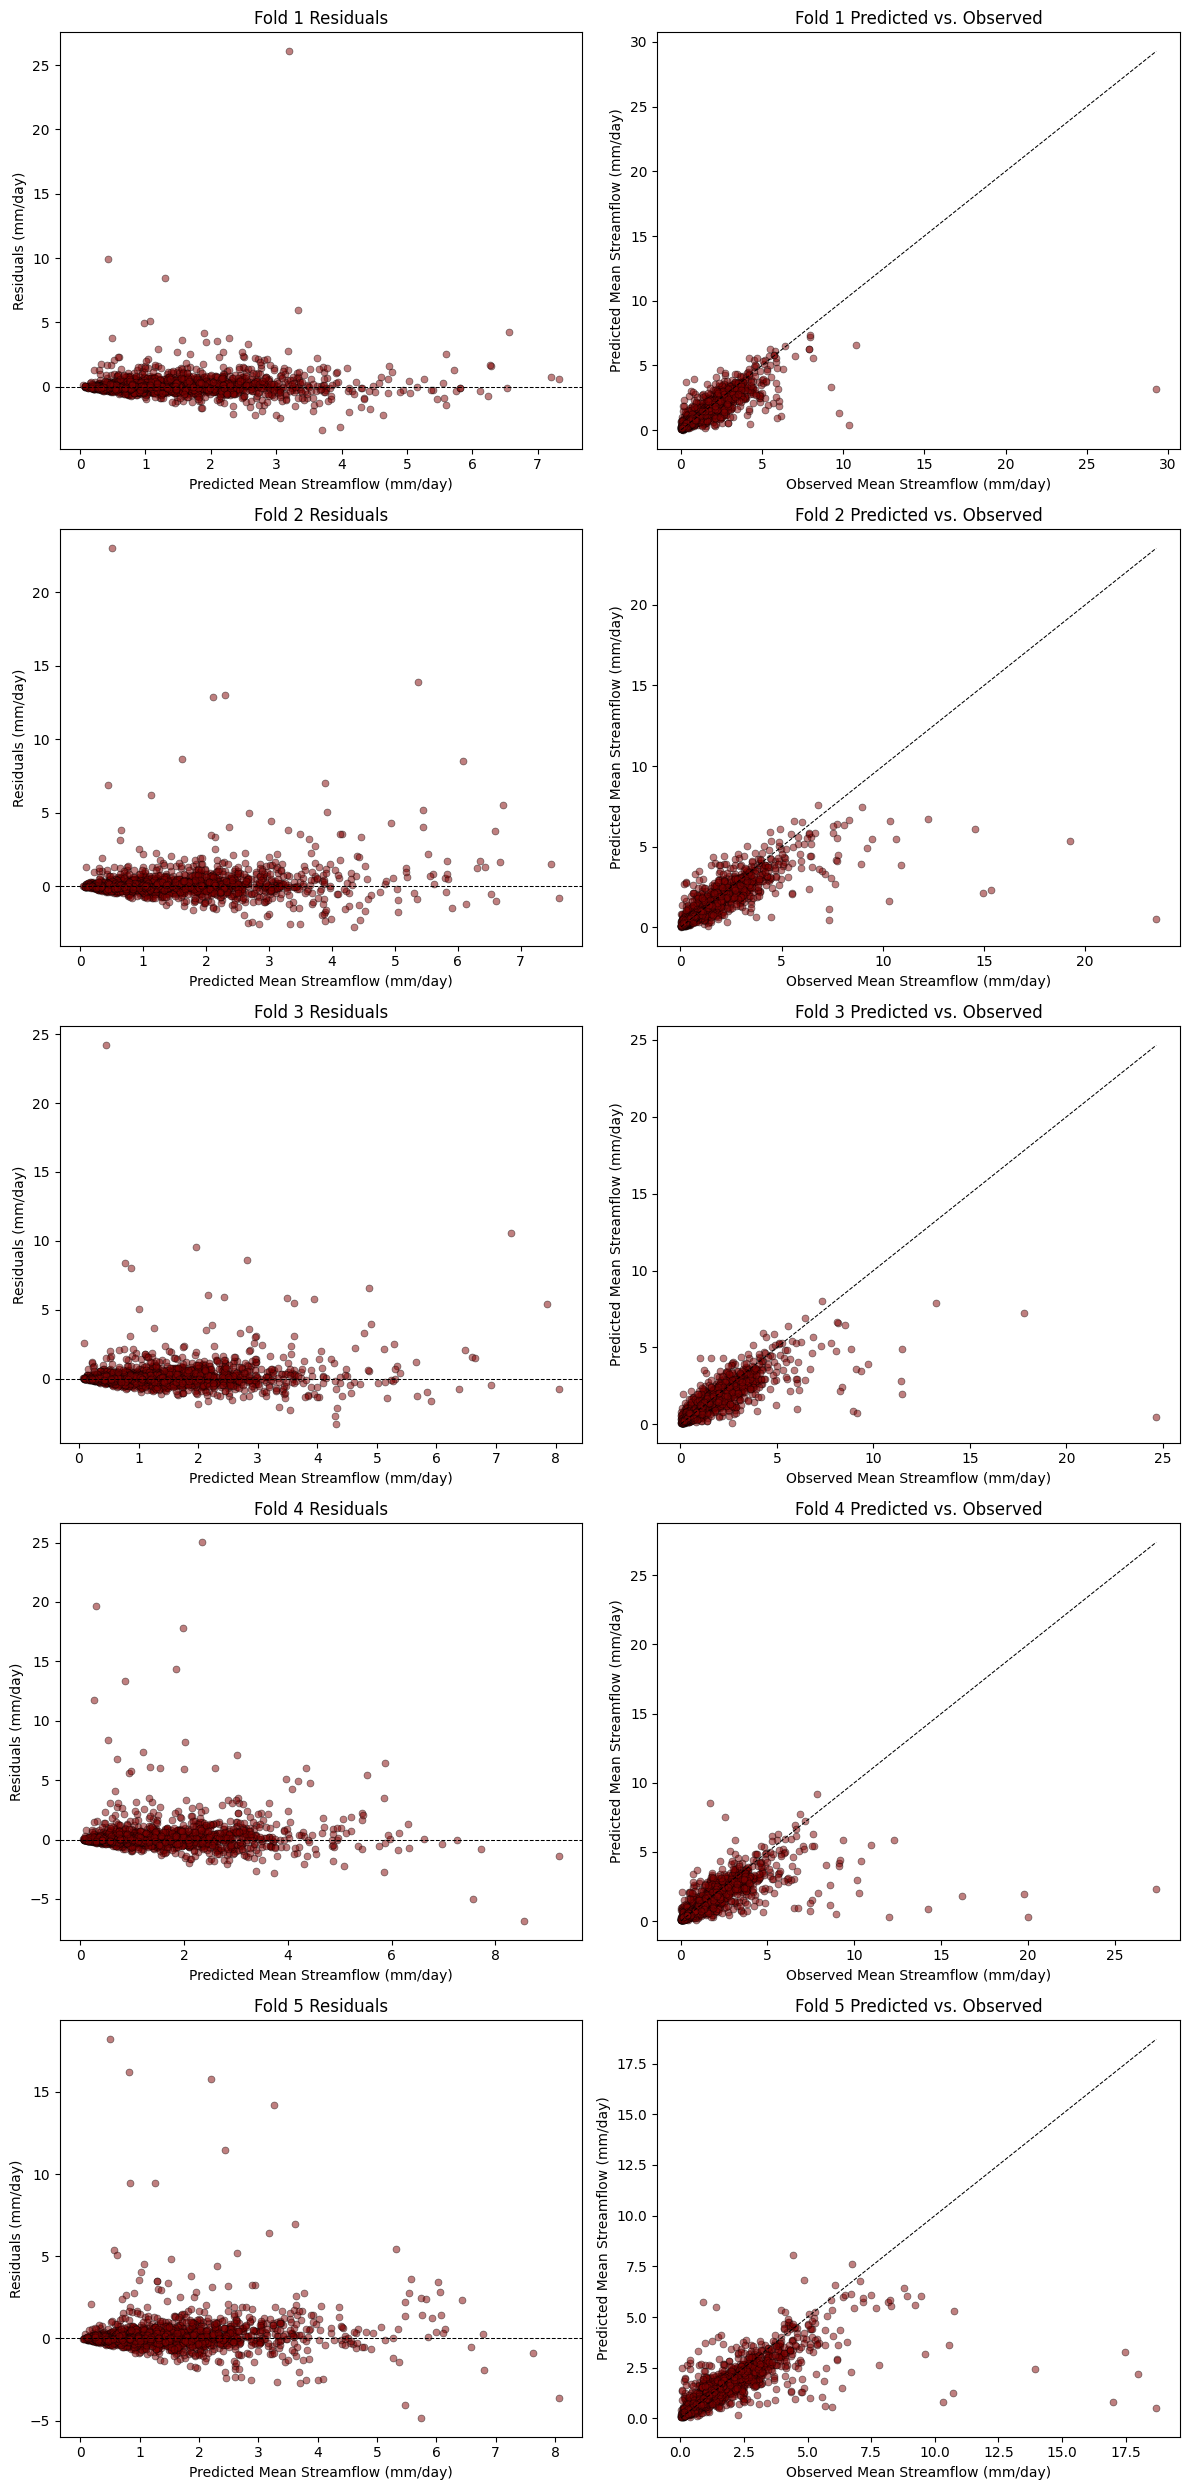

The average 5-Fold CV RMSE (original scale) is 0.927 mm/day
The average 5-Fold CV MAE (original scale) is 0.341 mm/day
The average 5-Fold CV R²   is 0.575


In [24]:
# Use evaluation function
xgb_rmse, xgb_mae, xgb_r2 = kfold_model_metrics(
    model_name="XGBoost",
    model_builder=build_xgb_pipeline,
    X=X,
    Y=y,
    cv=5,
    save_path = os.path.join(BASE_DIR, "mean_regression", "figures")
)

## Step 4. Final Model Training

In [ ]:
# Final model with best params
xgb_model = Pipeline([
    ('preproc', preprocessor),
    ('xgb', xgb.XGBRegressor(**best_params))
])

# Fit model
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-Squared:   {r2:.4f}")

Test RMSE: 0.4121
Test R-Squared:   0.7659


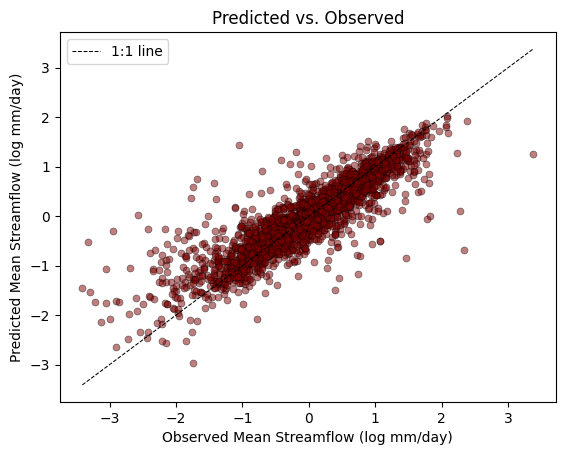

In [ ]:
# Flatten test/pred dfs
y_test_np = np.array(y_test).flatten()
y_pred_np = np.array(y_pred).flatten()

# Final Predicted vs Observed Plot
plt.scatter(y_test_np, y_pred_np, color='maroon', edgecolors='black', s=25, linewidths=0.5, alpha=0.5)
lims = [
    min(y_test_np.min(), y_pred_np.min()),
    max(y_test_np.max(), y_pred_np.max())
]
plt.plot(lims, lims, '--k', linewidth=0.75, label='1:1 line')
plt.title(f"Predicted vs. Observed")
plt.xlabel("Observed Mean Streamflow (log mm/day)")
plt.ylabel("Predicted Mean Streamflow (log mm/day)")
plt.legend()

# Save fig
true_obv_path = os.path.join(BASE_DIR, 'mean_regression', 'figures', 'true_vs_obs_scatter.png')
plt.savefig(true_obv_path, dpi=300, bbox_inches='tight')

# Display plot
plt.show()

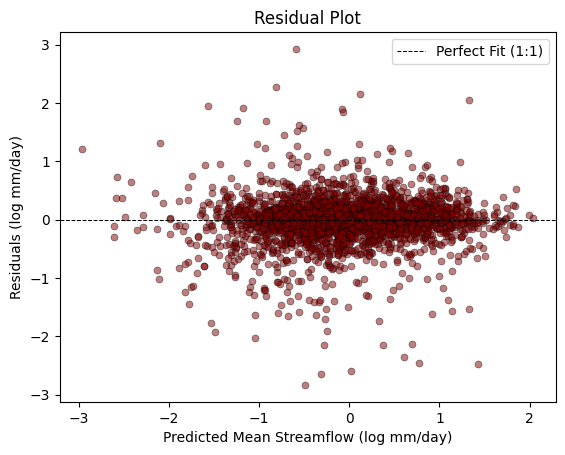

In [ ]:
# Calculate residuals
residuals = y_test_np - y_pred_np

# Final residual plot
plt.scatter(y_pred_np, residuals, color='maroon', edgecolors='black', s=25, linewidths=0.5, alpha=0.5)
plt.axhline(0, color='black', linestyle='dashed', linewidth=0.75, label='Perfect Fit (1:1)')
plt.title(f"Residual Plot")
plt.xlabel("Predicted Mean Streamflow (log mm/day)")
plt.ylabel("Residuals (log mm/day)")
plt.legend()

# Save fig
resid_path = os.path.join(BASE_DIR, 'mean_regression', 'figures', 'residual_scatter.png')
plt.savefig(resid_path, dpi=300, bbox_inches='tight')

# Display plot
plt.show()

### Step 4a. Save Model

In [ ]:
# Save the trained XGBoost model
mdl_path = os.path.join(BASE_DIR, 'xai', 'models_and_data', 'mean_reg', 'xgboost_model.pkl')

# Save model
joblib.dump(xgb_model, mdl_path)
print(f'XGBoost model saved as {mdl_path}')

XGBoost model saved as /content/HydroLearners_Proj/mean_regression/xgboost_model.pkl


## Step 5. Save Evaluation Data

We're also going to join the evaluation data (residuals, predicted) to lat/lon data for later plotting in GIS.

In [ ]:
# Define path
info_path = os.path.join(BASE_DIR, 'raw_data', 'estreams_gauging_stations.csv')
# Read in df
info_df = pd.read_csv(info_path)
info_df = info_df[['basin_id', 'lon','lat']].rename(columns = {'basin_id':'Basin ID'})

In [ ]:
# Get predictions & residuals (as Series, with the same index as X_test):
y_pred_series = pd.Series(y_pred, index=X_test.index, name='Predicted (log mm/day)')
y_obs_series = pd.Series(y_test, index=X_test.index, name='Mean Daily Streamflow (log mm/day)')
residuals_series = y_obs_series - y_pred_series
residuals_series.name = 'Residuals (log mm/day)'

# Pull in Basin ID
basin_series = reg_df.loc[X_test.index, 'Basin ID']

# Assemble a single DataFrame
test_df = (
    X_test
      .join([ basin_series,
              y_obs_series,
              y_pred_series,
              residuals_series ])
)

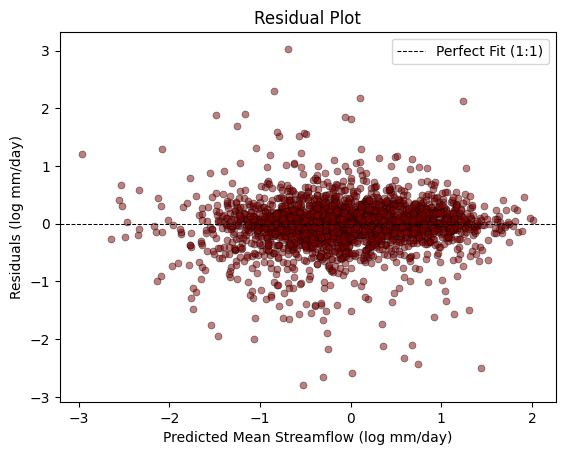

In [ ]:
# ------ Check they look the same ------

# Final residual plot
plt.scatter(test_df['Predicted (log mm/day)'], test_df['Residuals (log mm/day)'],
            color='maroon', edgecolors='black', s=25, linewidths=0.5, alpha=0.5)
plt.axhline(0, color='black', linestyle='dashed', linewidth=0.75, label='Perfect Fit (1:1)')
plt.title(f"Residual Plot")
plt.xlabel("Predicted Mean Streamflow (log mm/day)")
plt.ylabel("Residuals (log mm/day)")
plt.legend()

# Display plot
plt.show()

In [ ]:
# Merge two dfs
reg_loc_df = test_df.merge(info_df,
                          how = 'left',
                          on = 'Basin ID')
# Display dataframe
reg_loc_df

,Ratio of PET/Precipitation,Days/Year of Low Precipitation,Mean Terrain Slope (Degrees),Depth to Bedrock,Mean Aug NDVI,Mean Leaf-Area Index,Mean % Soil Organic Material,Min Elevation (m),Mean % Gravel in Soil,Mean NDVI,...,Days/Year with No Flow,% Metamorphics,Stream Density (1000km/km2),Lithological Dominant Class (Grouped),Basin ID,Mean Daily Streamflow (log mm/day),Predicted (log mm/day),Residuals (log mm/day),lon,lat
0,0.834,224.900,2.262,21.535,0.629,0.145,6.824,14.662,3.766,0.578,...,0.000,0.000,0.178,Unconsolidated Sediments,DK000162,0.034402,0.009526,0.024876,9.669666,56.297340
1,0.779,225.839,1.809,24.464,0.722,0.438,17.754,50.131,5.651,0.381,...,0.000,85.695,0.205,Metamorphics,FI000581,0.076036,0.100861,-0.024825,25.912053,65.359214
2,0.613,219.199,15.580,0.953,0.795,0.176,5.822,614.872,6.676,0.617,...,0.000,0.000,0.271,Siliciclastic Sedimentary,FR001890,1.069184,1.246204,-0.177020,2.444682,44.923603
3,0.907,239.187,15.391,5.605,0.756,0.190,1.848,221.966,13.123,0.634,...,0.000,0.000,0.198,Carbonate Sedimentary,AT000367,-0.366724,-0.203564,-0.163159,16.333165,47.933211
4,1.017,224.397,2.583,1.000,0.731,0.183,4.441,234.129,7.538,0.644,...,0.000,0.000,0.048,Mixed Sedimentary,FR000150,-0.320204,-0.309397,-0.010807,6.626502,48.597117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,0.428,179.814,10.392,0.921,0.697,0.157,4.598,82.575,8.925,0.615,...,0.000,0.000,0.101,Carbonate Sedimentary,GB000530,1.514028,1.524306,-0.010278,-4.240000,52.960000
2681,2.075,277.516,2.797,16.040,0.374,0.071,1.050,714.697,12.884,0.444,...,0.124,0.000,0.149,Mixed Sedimentary,ES000309,-2.055717,-1.580742,-0.474975,-5.872693,42.039453
2682,0.893,231.921,10.729,0.989,0.778,0.192,1.701,385.757,13.911,0.675,...,0.000,2.652,0.164,Acid Plutonic,FR003794,0.212690,0.303096,-0.090406,4.002999,45.743323
2683,0.992,227.567,5.112,1.052,0.668,0.150,1.429,275.151,7.164,0.571,...,0.000,57.892,0.153,Metamorphics,DESN1556,-0.401970,-0.286653,-0.115317,12.168172,50.610847


In [ ]:
# Save dataframe for later eval
loc_path = os.path.join(BASE_DIR, 'xai', 'models_and_data', 'reg_loc.csv')
reg_loc_df.to_csv(loc_path, index=False)

## P.S. Read in Existing Model
Here's the code if you just want the model that was already tuned :).

In [10]:
# Define paths (again, just in case)
model_path = os.path.join(BASE_DIR, 'xai', 'models_and_data', 'mean_reg', 'xgboost_model.pkl')
train_test_path = os.path.join(BASE_DIR, 'xai', 'models_and_data', 'mean_reg', 'xgb_train_test.pkl')
params_path = os.path.join(BASE_DIR, 'xai', 'models_and_data', 'mean_reg', 'optuna_best_params.json')

# Load in model/data/params
xgb_model = joblib.load(model_path)
X_train, X_test, y_train, y_test = joblib.load(train_test_path)
with open(params_path, 'r') as f:
    best_params = json.load(f)